### RidgeCV for daily MW modeling (2017 Monsoon, India)

Optimal lag (days), R² and p-value for each PC mode:
     best_lag        R2       p_value
x1        0.0  0.877887  4.951263e-85
x10       8.0  0.038091  9.437810e-03
x11       0.0  0.778524  1.777360e-61
x12      29.0  0.587080  3.437903e-31
x13      24.0  0.057374  2.283833e-03
x14      17.0  0.107033  1.592907e-05
x15      23.0  0.055648  2.590859e-03
x16      11.0  0.010026  1.899428e-01
x17      19.0  0.058123  1.811995e-03
x18       0.0  0.024847  3.259792e-02
x19      13.0  0.067659  5.907907e-04
x2       29.0  0.488794  4.666908e-24
x20      18.0  0.036836  1.324231e-02
x3       12.0  0.039489  8.967513e-03
x4       24.0  0.033071  2.136393e-02
x5       23.0  0.116222  9.630996e-06
x6        0.0  0.011765  1.427504e-01
x7       25.0  0.051449  4.038600e-03
x8       19.0  0.047911  4.734173e-03
x9       23.0  0.057221  2.242544e-03
Weighted average optimal lag (days) among significant modes: 13.08
Best alpha chosen by RidgeCV: 0.351
RidgeCV Regression: R² = 0.951, MSE = 0.01


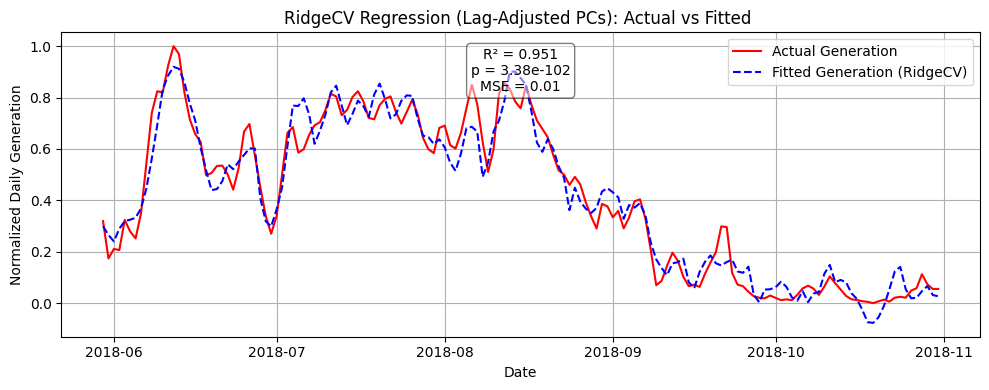

<Figure size 800x600 with 0 Axes>

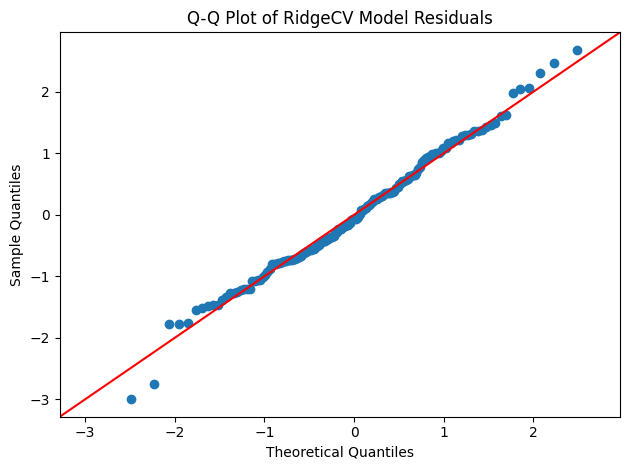

<Figure size 1000x400 with 0 Axes>

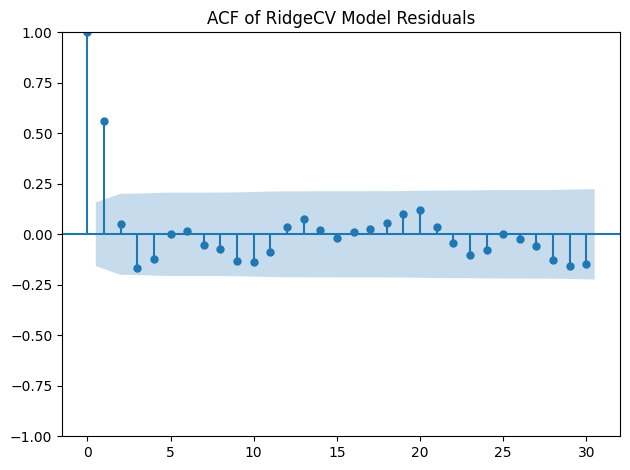

<Figure size 1000x400 with 0 Axes>

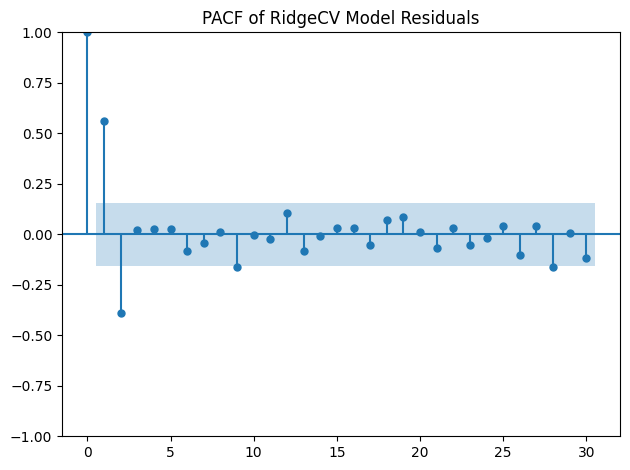

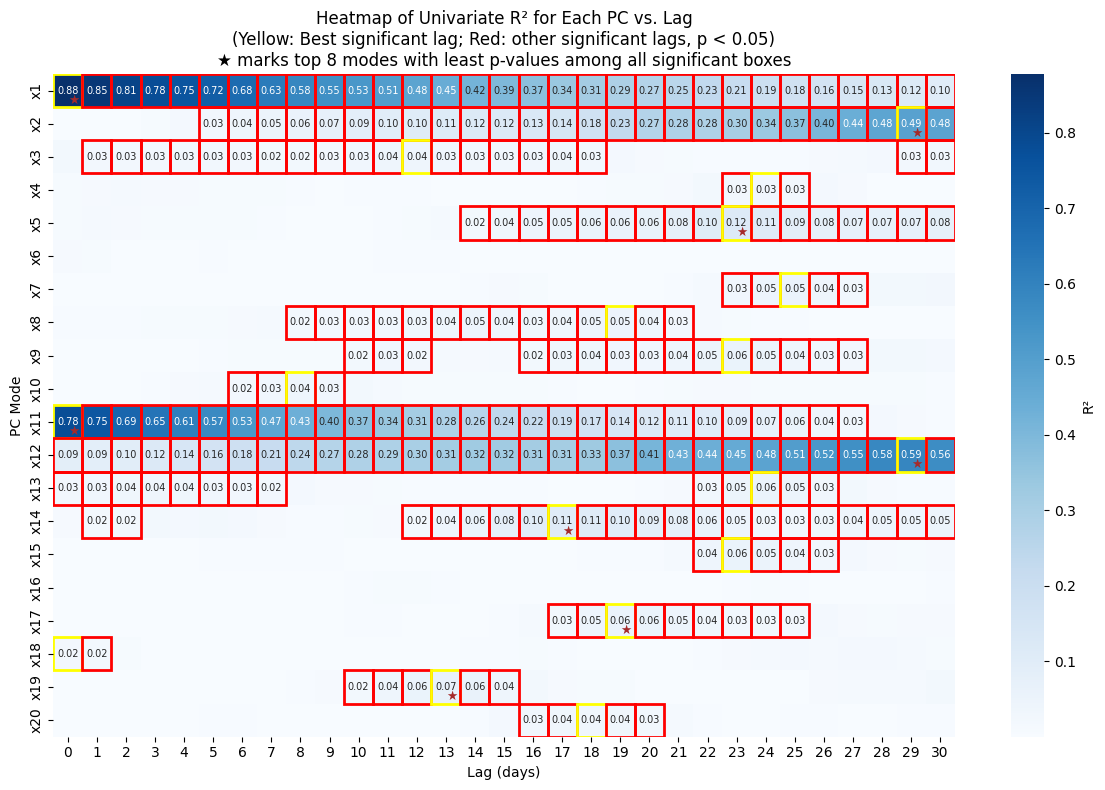


Optimal Lag, R², and p-values for each PC mode:
     best_lag        R2       p_value
x1        0.0  0.877887  4.951263e-85
x10       8.0  0.038091  9.437810e-03
x11       0.0  0.778524  1.777360e-61
x12      29.0  0.587080  3.437903e-31
x13      24.0  0.057374  2.283833e-03
x14      17.0  0.107033  1.592907e-05
x15      23.0  0.055648  2.590859e-03
x16      11.0  0.010026  1.899428e-01
x17      19.0  0.058123  1.811995e-03
x18       0.0  0.024847  3.259792e-02
x19      13.0  0.067659  5.907907e-04
x2       29.0  0.488794  4.666908e-24
x20      18.0  0.036836  1.324231e-02
x3       12.0  0.039489  8.967513e-03
x4       24.0  0.033071  2.136393e-02
x5       23.0  0.116222  9.630996e-06
x6        0.0  0.011765  1.427504e-01
x7       25.0  0.051449  4.038600e-03
x8       19.0  0.047911  4.734173e-03
x9       23.0  0.057221  2.242544e-03


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patches as patches

# Load PC Time Series
keadv_PC_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/india_country/pc/keadv_PC_time_series_monsoon_2018.parquet')
kegen_PC_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/india_country/pc/kegen_PC_time_series_monsoon_2018.parquet')

keadv_PC_df.index = pd.to_datetime(keadv_PC_df.index)
kegen_PC_df.index = pd.to_datetime(kegen_PC_df.index)

keadv_top10 = keadv_PC_df[[f'PC{i}' for i in range(1, 11)]].copy()
kegen_top10 = kegen_PC_df[[f'PC{i}' for i in range(1, 11)]].copy()
keadv_top10.columns = [f'x{i}' for i in range(1, 11)]
kegen_top10.columns = [f'x{i}' for i in range(11, 21)]

pc_combined = pd.concat([keadv_top10, kegen_top10], axis=1, join='inner')

# Load and clean generation data
df_gen = pd.read_parquet('/vol/sandeep_storage/Files2/countries/india_weighted_years/India_2018_daily_weighted_avg_gen_with_valid_time.parquet')
df_gen['valid_time'] = pd.to_datetime(df_gen['valid_time'])
df_gen.set_index('valid_time', inplace=True)
df_gen = df_gen[~df_gen.index.duplicated()]
gen_series = df_gen['Daily Weighted Avg Generation (MW)']

combined_for_opt = pd.concat([pc_combined, gen_series], axis=1, join='inner')
combined_for_opt.columns = list(pc_combined.columns) + ['y']

# Stage 1: Optimal Lag Selection
max_lag = 30
optimal_info = {}
r2_matrix = pd.DataFrame(index=pc_combined.columns, columns=range(max_lag+1))
pval_matrix = pd.DataFrame(index=pc_combined.columns, columns=range(max_lag+1))

for pc in pc_combined.columns:
    best_r2 = -np.inf
    best_lag = None
    best_p = None
    fallback_r2 = -np.inf
    fallback_lag = 0
    fallback_p = np.nan

    for lag in range(0, max_lag + 1):
        lagged_series = pc_combined[pc].shift(lag)
        df_temp = pd.concat([lagged_series, gen_series], axis=1).dropna()
        df_temp.columns = ['X', 'y']
        if len(df_temp) > 0:
            model = sm.OLS(df_temp['y'], sm.add_constant(df_temp['X'])).fit()
            current_r2 = model.rsquared
            current_p = model.pvalues.get('X', np.nan)
            r2_matrix.loc[pc, lag] = current_r2
            pval_matrix.loc[pc, lag] = current_p
            if current_r2 > fallback_r2:
                fallback_r2 = current_r2
                fallback_lag = lag
                fallback_p = current_p
            if current_p < 0.05 and current_r2 > best_r2:
                best_r2 = current_r2
                best_lag = lag
                best_p = current_p

    if best_lag is None:
        best_lag = fallback_lag
        best_r2 = fallback_r2
        best_p = fallback_p

    optimal_info[pc] = {'best_lag': best_lag, 'R2': best_r2, 'p_value': best_p}

optimal_df = pd.DataFrame(optimal_info).T.sort_index()
print("Optimal lag (days), R² and p-value for each PC mode:")
print(optimal_df)

signif_modes = optimal_df[optimal_df['p_value'] < 0.05]
if not signif_modes.empty:
    weighted_avg_lag = (signif_modes['best_lag'] * signif_modes['R2']).sum() / signif_modes['R2'].sum()
    print(f"Weighted average optimal lag (days) among significant modes: {weighted_avg_lag:.2f}")
else:
    print("No significant modes (p < 0.05) found.")

# Stage 2: Lag-Adjusted RidgeCV Regression
pc_optimal = pd.DataFrame(index=pc_combined.index)
for pc in pc_combined.columns:
    opt_lag = optimal_info[pc]['best_lag']
    pc_optimal[pc] = pc_combined[pc].shift(opt_lag)

weights = np.array([optimal_info[pc]['R2'] for pc in pc_combined.columns])
normalized_weights = weights / weights.sum()
composite_PC_optimal = pc_optimal.dot(normalized_weights)
composite_PC_optimal.name = 'Composite_PC_optimal'

X_opt = pc_optimal.copy()
data_opt = pd.concat([X_opt, gen_series], axis=1, join='inner').dropna()
data_opt.columns = list(pc_optimal.columns) + ['y']

X_mult = data_opt[pc_combined.columns]
y_mult = data_opt['y']

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_std = scaler_X.fit_transform(X_mult)
y_std = scaler_y.fit_transform(y_mult.values.reshape(-1, 1)).flatten()

# RidgeCV with built-in alpha selection
alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(X_std, y_std)
y_pred_std = ridge_cv.predict(X_std)
y_pred = scaler_y.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()

best_alpha = ridge_cv.alpha_
print(f"Best alpha chosen by RidgeCV: {best_alpha:.3f}")

r2_ridge = r2_score(y_mult, y_pred)
mse_ridge = mean_squared_error(y_mult, y_pred)
print(f"RidgeCV Regression: R² = {r2_ridge:.3f}, MSE = {mse_ridge:.2f}")

# ---- UPDATED PLOT: Actual vs Fitted (Normalized) ----
plt.figure(figsize=(10, 4))

# Normalize y_mult and y_pred to [0, 1] range for visualization
y_min, y_max = y_mult.min(), y_mult.max()
y_mult_norm = (y_mult - y_min) / (y_max - y_min)
y_pred_norm = (y_pred - y_min) / (y_max - y_min)

plt.plot(data_opt.index, y_mult_norm, label="Actual Generation ", color='red')
plt.plot(data_opt.index, y_pred_norm, label="Fitted Generation (RidgeCV)", linestyle="--", color='blue')
plt.xlabel("Date")
plt.ylabel("Normalized Daily Generation")
plt.title("RidgeCV Regression (Lag-Adjusted PCs): Actual vs Fitted ")
r_model, p_model = pearsonr(y_mult, y_pred)
plt.text(0.5, 0.95, f"R² = {(r_model**2):.3f}\np = {p_model:.3g}\nMSE = {mse_ridge:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center',
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ---- END OF UPDATED SECTION ----

# Residual Diagnostics
residuals = y_mult - y_pred
plt.figure(figsize=(8, 6))
qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of RidgeCV Model Residuals")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=30)
plt.title("ACF of RidgeCV Model Residuals")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(residuals, lags=30)
plt.title("PACF of RidgeCV Model Residuals")
plt.tight_layout()
plt.show()

# Heatmap for R² vs lag
r2_matrix = r2_matrix.astype(float)
pval_matrix = pval_matrix.astype(float)

annot = pd.DataFrame("", index=r2_matrix.index, columns=r2_matrix.columns)
for i in range(r2_matrix.shape[0]):
    for j in range(r2_matrix.shape[1]):
        try:
            p_val = float(pval_matrix.iloc[i, j])
        except:
            p_val = np.nan
        if not np.isnan(p_val) and p_val < 0.05:
            annot.iloc[i, j] = f"{r2_matrix.iloc[i, j]:.2f}"
        else:
            annot.iloc[i, j] = ""

plt.figure(figsize=(12, 8))
ax = sns.heatmap(r2_matrix, annot=annot, fmt="", cmap="Blues", cbar_kws={'label': 'R²'}, annot_kws={"fontsize": 7})

min_p_dict = {}
for pc in pval_matrix.index:
    min_val = np.inf
    best_lag_for_star = None
    for lag in pval_matrix.columns:
        try:
            p_val = float(pval_matrix.loc[pc, lag])
        except:
            p_val = np.nan
        if not np.isnan(p_val) and p_val < 0.05 and p_val < min_val:
            min_val = p_val
            best_lag_for_star = lag
    if best_lag_for_star is not None:
        min_p_dict[pc] = (min_val, best_lag_for_star)

sorted_modes = sorted(min_p_dict.items(), key=lambda x: x[1][0])
top_6_modes = [item[0] for item in sorted_modes[:8]]

for i in range(r2_matrix.shape[0]):
    pc = r2_matrix.index[i]
    best_lag_for_pc = optimal_info[pc]['best_lag']
    for j in range(r2_matrix.shape[1]):
        try:
            p_val = float(pval_matrix.iloc[i, j])
        except:
            p_val = np.nan
        if not np.isnan(p_val) and p_val < 0.05:
            edge_color = 'yellow' if j == best_lag_for_pc else 'red'
            ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=False, edgecolor=edge_color, lw=2))
            if pc in top_6_modes and j == min_p_dict[pc][1]:
                ax.text(j+0.5, i+0.6, "★", horizontalalignment='left', verticalalignment='top',
                        color='brown', fontsize=9)

plt.xlabel("Lag (days)")
plt.ylabel("PC Mode")
plt.title("Heatmap of Univariate R² for Each PC vs. Lag\n(Yellow: Best significant lag; Red: other significant lags, p < 0.05)\n★ marks top 8 modes with least p-values among all significant boxes")
plt.tight_layout()
plt.show()

print("\nOptimal Lag, R², and p-values for each PC mode:")
print(optimal_df)


In [2]:

# Prepare the top 10 modes from earlier sorted_modes (already contains lowest p-values)
top10_summary = []

print("\nTop 10 Most Statistically Significant PC Modes (based on lowest p-values):\n")
print("{:<6} {:<10} {:<8} {:<10}".format("Mode", "Best Lag", "R²", "p-value"))
print("-" * 40)
for mode, (pval, lag) in sorted_modes[:10]:
    r2_val = r2_matrix.loc[mode, lag]
    print("{:<6} {:<10} {:<8.3f} {:<10.3g}".format(mode, lag, r2_val, pval))
    top10_summary.append((mode, lag, r2_val, pval))

# Optionally: Store in DataFrame for later export or use
top10_df = pd.DataFrame(top10_summary, columns=["Mode", "Best Lag", "R²", "p-value"])



Top 10 Most Statistically Significant PC Modes (based on lowest p-values):

Mode   Best Lag   R²       p-value   
----------------------------------------
x1     0          0.878    4.95e-85  
x11    0          0.779    1.78e-61  
x12    29         0.587    3.44e-31  
x2     29         0.489    4.67e-24  
x5     23         0.116    9.63e-06  
x14    17         0.107    1.59e-05  
x19    13         0.068    0.000591  
x17    19         0.058    0.00181   
x9     23         0.057    0.00224   
x13    24         0.057    0.00228   


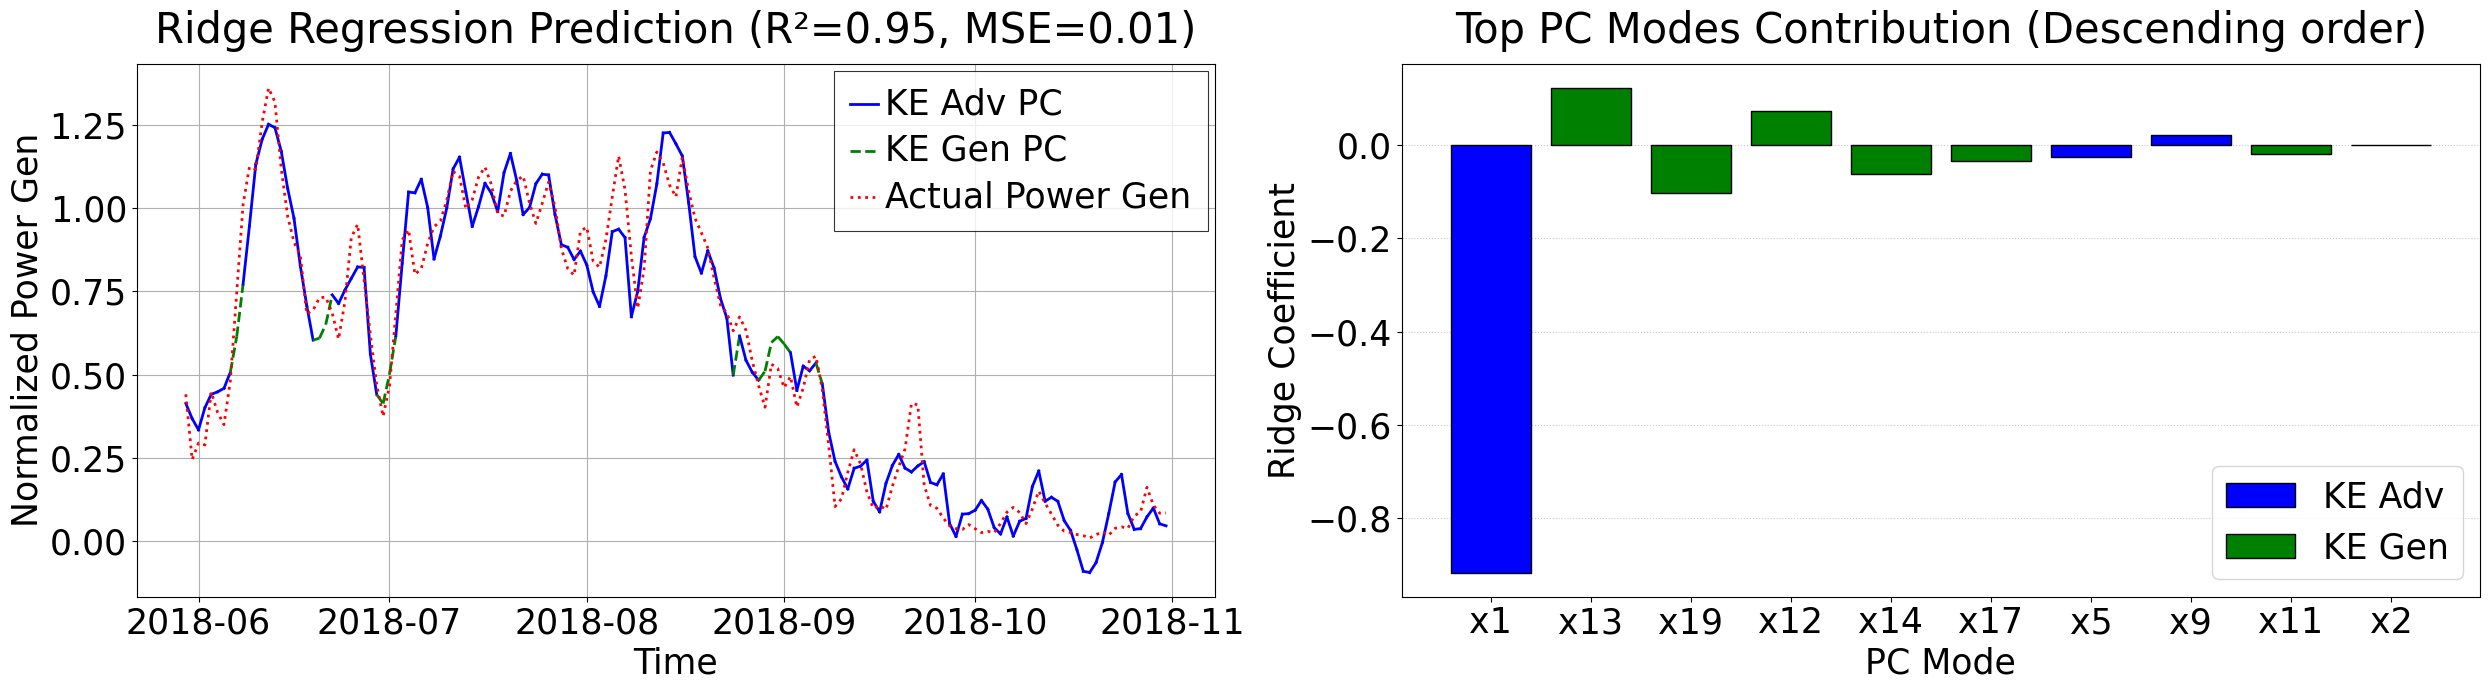

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, HPacker, DrawingArea, TextArea
from matplotlib.patches import Patch
from scipy.stats import pearsonr

# === Step 0: Prepare data ===
# Assuming X_std, X_mult, ridge, y_mult, y_pred, data_opt, pc_combined are already defined

# === Step 1: Define top 10 significant PCs ===
significant_pcs = ['x1', 'x11', 'x12', 'x2', 'x5', 'x14', 'x19', 'x17', 'x9', 'x13']
ke_adv_pcs = set([f'x{i}' for i in range(1, 11)])
ke_gen_pcs = set([f'x{i}' for i in range(11, 21)])
pc_group_map = {pc: 'adv' if pc in ke_adv_pcs else 'gen' for pc in significant_pcs}
pc_group_map_bars = {pc: 'KE Adv' if pc in ke_adv_pcs else 'KE Gen' for pc in significant_pcs}

# === Step 2: Determine dominant PC per timestep among top 10 PCs ===
X_std_df = pd.DataFrame(X_std, columns=pc_combined.columns, index=data_opt.index)
contributions = X_std_df.mul(ridge_cv.coef_, axis=1)
dominant_pc = contributions[significant_pcs].abs().idxmax(axis=1)
dominant_group = dominant_pc.map(pc_group_map)

# === Step 3: Compute Ridge statistics ===
r2_ridge = r2_score(y_mult, y_pred)
mse_ridge = mean_squared_error(y_mult, y_pred)

# === Step 4: Prepare contributions DataFrame for bar plot ===
ridge_coeffs = pd.Series(ridge_cv.coef_, index=X_mult.columns)
contributions_df = pd.DataFrame({
    'PC': significant_pcs,
    'Coefficient': ridge_coeffs[significant_pcs],
    'Abs_Coefficient': ridge_coeffs[significant_pcs].abs(),
    'Group': [pc_group_map_bars[pc] for pc in significant_pcs]
})
contributions_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

# === Step 5: Create subplots ===
fig, axs = plt.subplots(1, 2, figsize=(25, 7))  # two equal-size subplots

# --- Left subplot: Ridge prediction ---
ax1 = axs[0]
for t in range(len(y_pred) - 1):
    group = dominant_group.iloc[t]
    if group == 'adv':
        ax1.plot(data_opt.index[t:t+2], y_pred[t:t+2], color='blue', linestyle='-', linewidth=2)
    else:
        ax1.plot(data_opt.index[t:t+2], y_pred[t:t+2], color='green', linestyle='--', linewidth=2)

ax1.plot(data_opt.index, y_mult, color='red', linestyle=':', linewidth=2)

ax1.set_xlabel("Time", fontsize=25)
ax1.set_ylabel(" Normalized Power Gen ", fontsize=25)
ax1.tick_params(axis='both', labelsize=25)
ax1.set_title(f"Ridge Regression Prediction (R²={r2_ridge:.2f}, MSE={mse_ridge:.2f})", fontsize=30,pad=15)
ax1.grid(True)

# Legend as small line segments
legend_lines_info = [
    ('KE Adv PC', 'blue', '-'),
    ('KE Gen PC', 'green', '--'),
    ('Actual Power Gen', 'red', ':')
]
legend_boxes = []
for label, color, ls in legend_lines_info:
    da = DrawingArea(20, 5, 0, 0)
    da.add_artist(Line2D([0, 20], [2.5, 2.5], color=color, linestyle=ls, lw=2))
    legend_boxes.append(HPacker(children=[da, TextArea(label, textprops=dict(color='black', fontsize=25))],
                                 align="center", pad=2, sep=5))
vpacker = VPacker(children=legend_boxes, align="left", pad=5, sep=5)
anchored_box = AnchoredOffsetbox(loc='upper right', child=vpacker, frameon=True, pad=0.5)
anchored_box.patch.set_facecolor('white')
anchored_box.patch.set_alpha(0.8)
anchored_box.patch.set_edgecolor('black')
anchored_box.patch.set_linewidth(0.8)
ax1.add_artist(anchored_box)

# --- Right subplot: Bar plot of top 10 PCs ---
ax2 = axs[1]
colors = contributions_df['Group'].map({'KE Adv': 'blue', 'KE Gen': 'green'})
bars = ax2.bar(contributions_df['PC'], contributions_df['Coefficient'], color=colors, edgecolor='black')
ax2.set_axisbelow(True)
ax2.grid(axis='y', linestyle=':', alpha=0.7)
ax2.set_title(f"Top PC Modes Contribution (Descending order)", fontsize=30,pad=15)
# Legend as colored squares
legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='KE Adv'),
    Patch(facecolor='green', edgecolor='black', label='KE Gen')
]
ax2.legend(handles=legend_elements, fontsize=25)

ax2.set_ylabel('Ridge Coefficient', fontsize=25)
ax2.set_xlabel('PC Mode', fontsize=25)
ax2.tick_params(axis='both', labelsize=25)
plt.setp(ax2.get_xticklabels(), rotation=0)


# Add A and B labels above each subplot (outside plot area)
#fig.text(0.002, 1.05, "A", fontsize=40, fontweight='bold', ha='left', va='top')  # left subplot
#fig.text(0.51, 1.05, "B", fontsize=40, fontweight='bold', ha='left', va='top')   # right subplot



plt.tight_layout()
plt.show()
